### VGG16

In [4]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

* weights 指定模型初始化的权重检查点
* include_top 指定模型最后是否包含密集连接分类器。默认情况下，这个密集连接分类器对应于ImageNet的1000个类别。因为我们打算使用自己的密集连接分类器（只有两个类别：cat和dog），所以不需要包含它
* input_shape 是输入到网络中的图像张量的形状。这个参数可选，不传这个参数，那么网络能够处理任意形状的输入

### VGG16的网络结构

In [5]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

最后的特征图形状为（4，4，512）。我们将在这个特征上添加一个密集连接分类器  
有两种可供选择
* 在你的数据集上运行卷积基，将输出保存成硬盘中的numpy数组，然后用这个数据座位输入，输入到独立的密集连接分类器中。  
  优点：速度快，计算代价低，因为对于每个输入图像只需运行一次卷积基，而卷积基是目前流程中计算代价最高的。  
  缺点：不能使用数据增强
* 在顶部添加Dense层来扩展已有模型（即conv_base），并在输入数据上端到端的运行整个模型  
  优点：可以使用数据增强，因为么个输入图喜庆进入模型时都会经过卷积基  
  缺点：相比上一种方法，计算代价高许多。

### 不使用数据增强的快速特征提取

#### 首先，运行ImageDataGenerator实例，将图像及标签提取为numpy数组。需要调用conv_base模型的predict方法从这些图像中提取特征

In [9]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/Users/schp/Desktop/样本/dogs-vs-cats-small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labeles = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary'
    )
    
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labeles[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labeles

train_features, train_lables = extract_features(train_dir, 2000)
validation_features, validation_lables = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

# 展平输出
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


#### 定义并训练密集连接分类器

In [20]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])
history = model.fit(
    train_features, train_lables,
    epochs=30,
    batch_size=20,
    validation_data=(validation_features, validation_lables)
)

W0820 13:18:49.746749 140736514884544 deprecation.py:506] From /Users/schp/miniconda2/envs/keras2.0.8/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:625: calling Constant.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 3s - loss: 0.6177 - acc: 0.6525 - val_loss: 0.4457 - val_acc: 0.8360
Epoch 2/30
2000/2000 [==============================] - 3s - loss: 0.4309 - acc: 0.8095 - val_loss: 0.3652 - val_acc: 0.8660
Epoch 3/30
2000/2000 [==============================] - 3s - loss: 0.3648 - acc: 0.8340 - val_loss: 0.3226 - val_acc: 0.8860
Epoch 4/30
2000/2000 [==============================] - 3s - loss: 0.3105 - acc: 0.8715 - val_loss: 0.3002 - val_acc: 0.8950
Epoch 5/30
2000/2000 [==============================] - 3s - loss: 0.2896 - acc: 0.8855 - val_loss: 0.2857 - val_acc: 0.8960
Epoch 6/30
2000/2000 [==============================] - 3s - loss: 0.2621 - acc: 0.8875 - val_loss: 0.2728 - val_acc: 0.8990
Epoch 7/30
2000/2000 [==============================] - 3s - loss: 0.2471 - acc: 0.9105 - val_loss: 0.2656 - val_acc: 0.8980
Epoch 8/30
2000/2000 [==============================] - 3s - loss: 0.2274 - a

#### 绘制结果

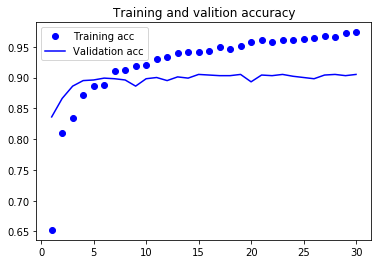

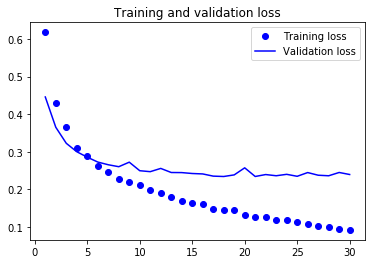

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and valition accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### 使用数据增强的特征提取

#### 在训练过程使用数据增强，速度慢，计算代价大，在cpu上难以运行

In [25]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)  # 将conv_base当作一层
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

W0820 14:18:45.201208 140736514884544 deprecation.py:506] From /Users/schp/miniconda2/envs/keras2.0.8/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:1205: calling reduce_prod_v1 (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


vgg16层的参数14714688个参数，在其上添加的分类器有200多万个参数。  
在编译和训练模型之前，一定要“冻结”卷积基。冻结一个或多个层是指在训练过程中保持其权重不变。如果不这么做，那么卷积基之前学到的表示将会在训练过程中被修改。因为其上添加的Dense层是随机初始化的，所以非常大的权重更新将会在网络中传播，对之前学到的表示造成很大的破坏。  

在karas中，冻结网络的方法是将其trainable属性设为False。

In [27]:
print('冻结前，训练的权重个数', len(model.trainable_weights))
conv_base.trainable = False
print('冻结后，训练的权重个数', len(model.trainable_weights))

冻结前，训练的权重个数 30
冻结后，训练的权重个数 4


#### 利用冻结的卷积基端到端地训练模型（在gpu上进行）
代码
```
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

model.compile(
    loss='binary_crossentropy'
    optimizer=optimizers.RMSprop(lr=2e-5),
    metrics=['acc']
)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)
```